### Advanced Machine Learning

# Home Exercise #1

Assignment Due: 21/03/21 23:59

Jonathan Schler


In [1]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="" # student2 ID here


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# add more imports as needed

## Task 1 Regression on Ames Housing Dataset (60 Points)

You can load the Ames housing dataset from <br>
http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls <br>
You can find a description of the variables here: <br>
http://jse.amstat.org/v19n3/decock/DataDocumentation.txt <br>
Take note that for categorical variables, NA here does not mean a missing value, but should be treated as a separate category.

In [3]:
df = pd.read_excel("AmesHousing.xls")
df.head()



,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Question 1.1
Visualize the univariate distribution of each continuous attribute, and the distribution of the target. Make sure you skip the string\categorial columns (you can do it using call to `select_dtypes(exclude=['object'])`).

Do you notice anything? Is there something that might require special treatment?

In [68]:
# TODO: should we skip more: for example 'MS subclass'
numerical_df = df.select_dtypes(exclude=['object']).drop(["SalePrice", "PID", "Order"], axis=1)
len(numerical_df.columns)

36

In [97]:
y = df.SalePrice
y_limit = y.max()
y.max()

755000

In [98]:
features_description = {
    "MS SubClass": "type of dwelling involved in the sale",
    "Lot Frontage": "Linear feet of street connected to property",
    "Lot Area": "Lot size in square feet",
    "Overall Qual": "Rates the overall material and finish of the house",
    "Overall Cond": "Rates the overall condition of the house",
    "Year Built": "Original construction date",
    "Year Remod/Add": "Remodel date (same as construction date if no remodeling or additions)",
    "Mas Vnr Area": "Masonry veneer area in square feet",
    "BsmtFin SF 1": "Type 1 finished square feet",
    "BsmtFin SF 2": "Type 2 finished square feet",
    "Bsmt Unf SF": "Unfinished square feet of basement area",
    "Total Bsmt SF": "Total square feet of basement area",
    "1st Flr SF": "First Floor square feet",
    "2nd Flr SF": "Second floor square feet",
    "Low Qual Fin SF": "Low quality finished square feet (all floors)",
    "Gr Liv Area": "Above grade (ground) living area square feet",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Bsmt Half Bath": "Basement half bathrooms",
    "Bsmt Full Bath": "Basement full bathrooms",
    "Full Bath": "Full bathrooms above grade",
    "Half Bath": "Half baths above grade",
    "Fireplaces": "Number of fireplaces",
    "Misc Val": "Value of miscellaneous feature",
    "3Ssn Porch": "Three season porch area in square feet"
}

In [101]:
title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

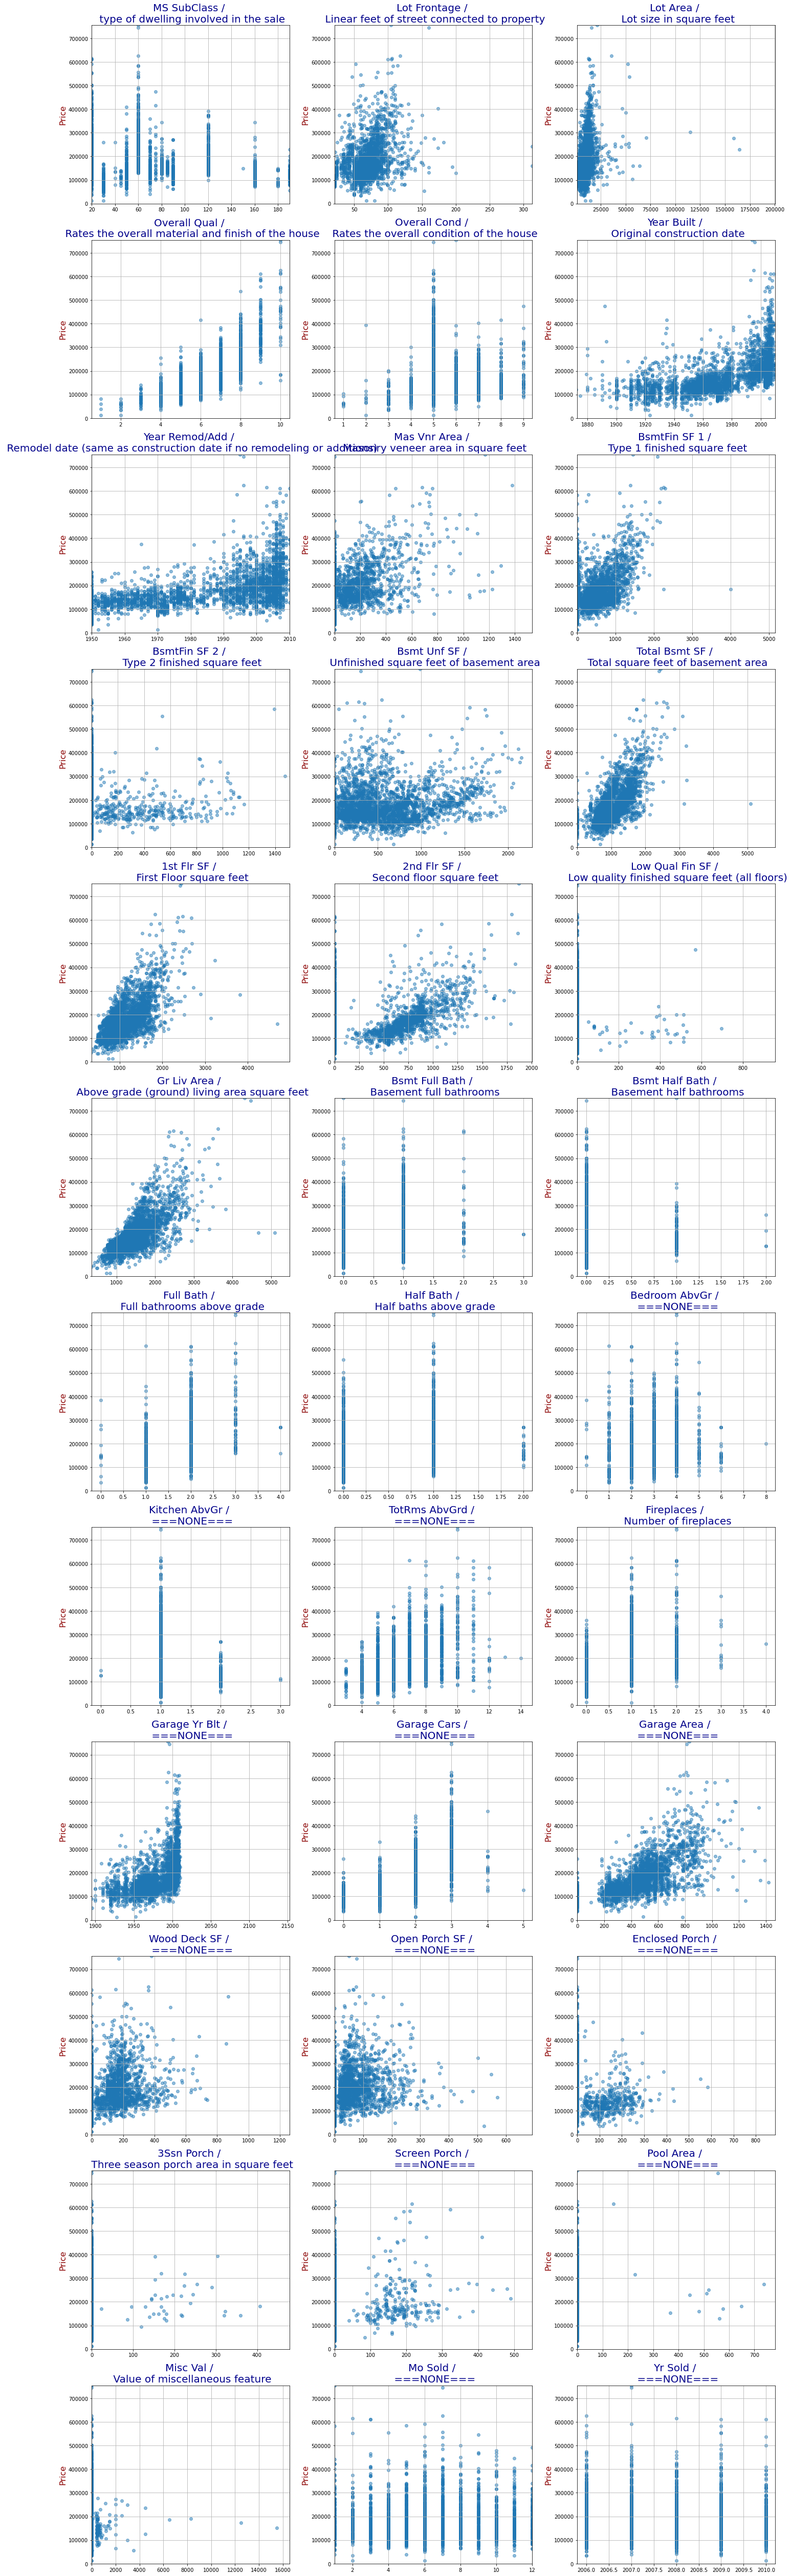

In [105]:
fig, axes = plt.subplots(12, 3, figsize=(20, 70))
y = df.SalePrice

for i, ax in enumerate(axes.ravel()):
    X_col = numerical_df.iloc[:, i]
    ax.set_ylim(0, y_limit)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
    ax.scatter(X_col, y, alpha=.5)

    feature_name = numerical_df.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Price", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()


explanation here...

### Question 1.2
Visualize the dependency of the target on each continuous feature (2d scatter plot).

In [14]:
# your code here

### Question 1.3
Split data in training and test set. Do not use the test-set unless for a final evaluation in 1.6.
For each categorical variable, cross-validate a Linear Regression model using just this variable
(one-hot-encoded). Visualize the relationship of the categorical variables that provide the best
R^2 value with the target.

In [15]:
# your code here

### Question 1.4
Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear
Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default
parameters. Does scaling the data (within the pipeline) with StandardScaler help?

In [16]:
# your code here

### Question 1.5
Tune the parameters of the models using GridSearchCV. Do the results improve?
Visualize the dependence of the validation score on the parameters for Ridge, Lasso and
ElasticNet.

In [17]:
# your code here

### Question 1.6
Visualize the coefficients of the resulting models. Do they agree on which features are
important?

In [18]:
# your code here

## Task 2 Classification on the Telco-churn dataset (40 points)

You can download the dataset and see it’s description at <br>
https://www.kaggle.com/blastchar/telco-customer-churn

### Question 2.1

Load the data from the file into a DataFrame

In [ ]:
# your code here

### Question 2.2

Split data into training and test set. Build a pipeline for dealing with categorical variables.
Evaluate Logistic Regression and nearest centroids using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [20]:
# your code here

### Question 2.3

Tune the parameters using GridSearchCV. Do the results improve?

In [ ]:
# your code here

### Question 2.4

Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [ ]:
# your code here

Good Luck!